In [4]:
import pandas as pd
pd.options.display.max_colwidth = 100
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from catboost import CatBoost, CatBoostClassifier, Pool, cv
import math


In [5]:
pd.set_option('display.max_colwidth', 20)
df = pd.read_csv("titanic_datasets/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen...",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. Jo...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss....",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. J...",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. Willi...",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
def get_data_y_features(df, is_train = False):
    data = df.copy()
    data.index = df.PassengerId
    features = data.columns
    pID = data.PassengerId
    data.drop(columns = ['PassengerId'], inplace=True)
    
    if is_train:
        y = data.Survived
        data.drop(columns = ['Survived'], inplace=True)
        return data, y, features
        
    return data, features

In [8]:
data, y, features = get_data_y_features(df, True)

In [9]:
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen...",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. Jo...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss....",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. J...",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. Willi...",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
features

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
data.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
test_df = pd.read_csv("titanic_datasets/test.csv")
test_data, test_features = get_data_y_features(test_df)

In [13]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. Jam...",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thoma...",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. A...",female,22.0,1,1,3101298,12.2875,NaN,S


In [14]:
test_features

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [15]:
test_data.describe()

,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


In [16]:
def model_fit(train_X, train_y, log, cross_val = False):
    categorical_features_indices =np.where(train_X.dtypes != np.float)[0] 
    X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2)
    train_pool = Pool(X_train,
                     y_train,
                     cat_features=categorical_features_indices)
    model = CatBoostClassifier(iterations=1000,
                            learning_rate=0.03,
                            eval_metric='Accuracy', 
                            loss_function='CrossEntropy',
                            random_seed=15,
                            logging_level=log,
                            train_dir="train_dir",
                            use_best_model = True)
    

    model.fit(train_pool,
             eval_set=(X_test, y_test),
             plot=False)
    
    print('Best Model iteration {iteration} with score {score}. Shrink to first {shrink} iterations'.format(
        iteration = model.get_best_iteration(),
        score= model.get_best_score(),
        shrink = model.get_best_iteration() + 1
    ))
    
    ##########################################################################
    if cross_val:
        cv_params = model.get_params()
        cv_params.update({
            'loss_function': 'Logloss',
            'logging_level' : log
        })

        cv_data = cv(
            Pool(train_X, train_y, cat_features=categorical_features_indices),
            cv_params,
            plot=False
            
        )

        print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
            np.max(cv_data['test-Accuracy-mean']),
            cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
            np.argmax(cv_data['test-Accuracy-mean'])
        ))
        
    
    model.shrink(model.get_best_iteration() + 1)  
    print("Model has been shrinked to", model.tree_count_)
    return model

In [17]:
def print_null_cols(df_null):
        return ["Column: {colname} NullNums: {nums}  Null: {per}%".format(colname = col,
                                                              nums= len(df_null[df_null[col].isnull() == True]),
                                                              per = math.ceil(len(df_null[df_null[col].isnull() == True])*100/len(df_null))) for col in df_null.columns ]


In [18]:
print_null_cols(data)

['Column: Pclass NullNums: 0  Null: 0%',
 'Column: Name NullNums: 0  Null: 0%',
 'Column: Sex NullNums: 0  Null: 0%',
 'Column: Age NullNums: 177  Null: 20%',
 'Column: SibSp NullNums: 0  Null: 0%',
 'Column: Parch NullNums: 0  Null: 0%',
 'Column: Ticket NullNums: 0  Null: 0%',
 'Column: Fare NullNums: 0  Null: 0%',
 'Column: Cabin NullNums: 687  Null: 78%',
 'Column: Embarked NullNums: 2  Null: 1%']

In [19]:
print_null_cols(test_data)

['Column: Pclass NullNums: 0  Null: 0%',
 'Column: Name NullNums: 0  Null: 0%',
 'Column: Sex NullNums: 0  Null: 0%',
 'Column: Age NullNums: 86  Null: 21%',
 'Column: SibSp NullNums: 0  Null: 0%',
 'Column: Parch NullNums: 0  Null: 0%',
 'Column: Ticket NullNums: 0  Null: 0%',
 'Column: Fare NullNums: 1  Null: 1%',
 'Column: Cabin NullNums: 327  Null: 79%',
 'Column: Embarked NullNums: 0  Null: 0%']

In [20]:
def split_on_name(train_data_sub):
    if 'First/Middle Name' in train_data_sub.columns:
        return train_data_sub
    else:
        last_name_split_sal = train_data_sub['Name'].str.split('[,.]', expand=True)
        if len(last_name_split_sal.columns) == 4:
            last_name_split_sal[3] = last_name_split_sal[3].apply(lambda s :  '' if s is None else str(s))
            last_name_split_sal['First/Middle Name'] = [ "{} {}".format(x, y) for x,y in zip(last_name_split_sal[2], last_name_split_sal[3])]
            last_name_split_sal = last_name_split_sal.drop(columns=[2,3])
            
        last_name_split_sal.columns = ['Last Name', 'Salutation', 'First/Middle Name']
        last_name_split_sal = last_name_split_sal.applymap(lambda x: x.strip())
        return train_data_sub.join(last_name_split_sal)

In [21]:
data = split_on_name(data)

In [22]:
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last Name,Salutation,First/Middle Name
PassengerId,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen...",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
2,1,"Cumings, Mrs. Jo...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Fl...
3,3,"Heikkinen, Miss....",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
4,1,"Futrelle, Mrs. J...",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (L...
5,3,"Allen, Mr. Willi...",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry


In [23]:
from catboost import CatBoostRegressor
    
def age_model_fit(t_X,
                  t_Y, 
                  ln,
                  depth,
                  iters,
                  log = 'Silent',
                  loss_funct = 'MAE',
                  cross_val = False):
    
    model = CatBoostRegressor(iterations=iters,
                            learning_rate=ln,
                            depth = depth,
                            loss_function=loss_funct,
                            random_seed=15,
                            logging_level=log,
                            train_dir="train_dir_age",
                            use_best_model = True)
    
    categorical_features_indices =np.where(t_X.dtypes != np.float)[0] 
    X_train, X_test, y_train, y_test = train_test_split(t_X, t_Y, test_size=0.2)
    train_pool = Pool(X_train,
                     y_train,
                     cat_features=categorical_features_indices)
    
    model.fit(train_pool, eval_set=(X_test, y_test))
    
    print('Best Model iteration {iteration} with score {score}. Shrink to first {shrink} iterations'.format(
        iteration = model.get_best_iteration(),
        score= model.get_best_score(),
        shrink = model.get_best_iteration() + 1
    ))
    
    if cross_val:
        cv_params = model.get_params()
        cv_params.update({
            'loss_function': loss_funct,
            'logging_level' : log
        })

        cv_data = cv(
            Pool(t_X, t_Y, cat_features=categorical_features_indices),
            cv_params
        )
        try:
            print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
                np.max(cv_data['test-Accuracy-mean']),
                cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
                np.argmax(cv_data['test-Accuracy-mean'])
            ))
        except:
            print('Exception during printing best validation score. Printing everything now: ')
            print(cv_data)

        
    model.shrink(model.get_best_iteration() + 1)  
    print("Model has been shrinked to", model.tree_count_)
    
    return model

def fill_age_train(features,
                   X,
                   ln =0.3,
                   depth =10,
                   iters =2000,
                   round_age = False, cross_vali = False):
    X_age = X[features].copy()
    

    X_age = X_age[(X_age['Age'].isnull() == False)]
    y = X_age['Age'].copy()
    X_age.drop(columns=['Age'], inplace=True)
    X_age.fillna(-999, inplace=True)
    age_model  = age_model_fit(X_age, y, ln, depth, iters, loss_funct = 'RMSE', cross_val=cross_vali)
    
    
    X_test = X[X['Age'].isnull() == True].drop(columns=['Age']).fillna(-999)
    
    test_pool = Pool(X_test, cat_features=np.where(X_test.dtypes != np.float)[0])
    predicted_ages = np.array(age_model.predict(test_pool))
    if round_age:
        predicted_ages =  [math.ceil(i) for i in predicted_ages]
    
    X.loc[X_test.index, 'Age'] = pd.Series(predicted_ages, X_test.index)
    
    return predicted_ages, X , age_model

In [24]:
features = ['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Salutation']

In [207]:
ages, df_ages_filled, age_model =  fill_age_train(features, data)

Best Model iteration 290 with score {'learn': {'RMSE': 3.685730246865822}, 'validation': {'RMSE': 10.31286368072584}}. Shrink to first 291 iterations
Model has been shrinked to 291


C:\Users\divjo\Anaconda3\envs\super\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [218]:
model = model_fit(df_ages_filled[features], 
                  y, 
                  log = 'Silent',
                  cross_val=True)

Best Model iteration 43 with score {'learn': {'Accuracy': 0.9578651685393258, 'CrossEntropy': 0.15278032636777053}, 'validation': {'Accuracy': 0.8379888268156425, 'CrossEntropy': 0.42860615521629836}}. Shrink to first 44 iterations
Best validation accuracy score: 0.83±0.03 on step 377
Model has been shrinked to 44


In [399]:
def update_null_ages_test(test_data, age_model,  round_age = False):
    test_data_name_split = split_on_name(test_data)
    test_features_age = features.copy()
    test_features_age.remove('Age')
    X_test = test_data_name_split[test_data_name_split['Age'].isnull() == True].drop(columns=['Age']).fillna(-999)[test_features_age]

    test_pool = Pool(X_test, cat_features=np.where(X_test.dtypes != np.float)[0])
    predicted_ages = np.array(age_model.predict(test_pool))
    if round_age:
        predicted_ages = [math.ceil(i) for i in predicted_ages]
    
    test_data_name_split.loc[X_test.index, 'Age'] = pd.Series(predicted_ages, X_test.index)
    return test_data_name_split


## Predict Result

In [ ]:
test_data = update_null_ages_test(test_data)

test_data.iloc[test_df['Age'].isnull().index]

test_data = test_data[features]
predictions = pd.Series( model.predict(Pool(test_data, cat_features=np.where(test_data.dtypes != np.float)[0])),
                        dtype=int)


pred_df = pd.DataFrame({'PassengerId': pd.Series(test_data.index), 'Survived' : predictions})
pred_df.to_csv('Submission_X.csv', index=False)

### Lets add more features:
#### + Last Name

In [387]:
features.append('Last Name')

In [388]:
model = model_fit(df_ages_filled[features], 
                  y, 
                  log = 'Silent',
                  cross_val=True)
features.remove('Last Name')

Best Model iteration 759 with score {'learn': {'Accuracy': 0.9578651685393258, 'CrossEntropy': 0.15848840593423563}, 'validation': {'Accuracy': 0.8659217877094972, 'CrossEntropy': 0.3901569963540316}}. Shrink to first 760 iterations
Best validation accuracy score: 0.84±0.05 on step 650
Model has been shrinked to 760


#### - Last Name
#### + Embarked

In [354]:
features.append('Embarked')

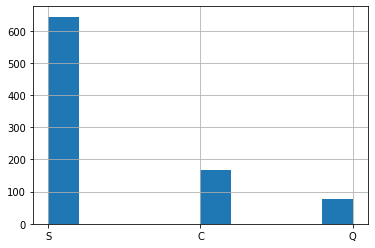

In [375]:
df[df['Embarked'].isnull() == False]['Embarked'].hist()

In [378]:
df_ages_filled['Embarked'] = df_ages_filled['Embarked'].fillna('S')
model = model_fit(df_ages_filled[features], 
                  y, 
                  log = 'Silent',
                  cross_val=True)

Best Model iteration 792 with score {'learn': {'Accuracy': 0.9536516853932584, 'CrossEntropy': 0.16226357350200937}, 'validation': {'Accuracy': 0.8603351955307262, 'CrossEntropy': 0.3581426750565498}}. Shrink to first 793 iterations
Best validation accuracy score: 0.83±0.02 on step 66
Model has been shrinked to 793


#### + Last Name
#### + Embarked

In [379]:
features.append('Last Name')
model = model_fit(df_ages_filled[features], 
                  y, 
                  log = 'Silent',
                  cross_val=True)

Best Model iteration 653 with score {'learn': {'Accuracy': 0.973314606741573, 'CrossEntropy': 0.1339781995850671}, 'validation': {'Accuracy': 0.8547486033519553, 'CrossEntropy': 0.41311107615341885}}. Shrink to first 654 iterations
Best validation accuracy score: 0.83±0.00 on step 45
Model has been shrinked to 654


# ----------------------------------------------------------------------------------------------------
# Lets improve age predictions

In [26]:
ages2, df_ages_filled2, age_model2 =  fill_age_train(['Pclass', 'Age', 'Sex', 'Fare', 'Salutation',  'Ticket' ,'SibSp', 'Parch'],
                                                     data,
                                                     ln=0.05,
                                                     depth=12,
                                                     iters=1000,
                                                     round_age=False)

Best Model iteration 70 with score {'learn': {'RMSE': 3.228326452532446}, 'validation': {'RMSE': 8.60717330389903}}. Shrink to first 71 iterations
Model has been shrinked to 71


In [ ]:
ages3, df_ages_filled3, age_model3 =  fill_age_train(['Pclass', 'Age', 'Sex', 'Fare', 'Salutation',  'Ticket' ,'SibSp', 'Parch'],
                                                     data,
                                                     ln=0.05,
                                                     depth=15,
                                                     iters=1000,
                                                     round_age=False)